In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clone and install MT-YOLOv6
!git clone https://github.com/meituan/YOLOv6.git
%cd YOLOv6
!pip install -r requirements.txt

In [ ]:
#@title Set-up model. { run: "auto" }
checkpoint:str ="best_stop_aug_ckpt" #@param ["best_stop_aug_ckpt","yolov6s", "yolov6n", "yolov6t","best_ckpt"]
device:str = "cpu"#@param ["gpu", "cpu"]
half:bool = False #@param {type:"boolean"}


import os, requests, torch, math, cv2
import numpy as np
import PIL
#Change directory so that imports wortk correctly
if os.getcwd()=="/content":
  os.chdir("YOLOv6")
from yolov6.utils.events import LOGGER, load_yaml
from yolov6.layers.common import DetectBackend
from yolov6.data.data_augment import letterbox
from yolov6.utils.nms import non_max_suppression
from yolov6.core.inferer import Inferer

from typing import List, Optional
#Download weights
if not os.path.exists(f"{checkpoint}.pt"):
  print("Downloading checkpoint...")
  os.system(f"""wget -c https://github.com/meituan/YOLOv6/releases/download/0.3.0/{checkpoint}.pt""")

#Set-up hardware options
cuda = device != 'cpu' and torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')
  
def check_img_size(img_size, s=32, floor=0):
  def make_divisible( x, divisor):
    # Upward revision the value x to make it evenly divisible by the divisor.
    return math.ceil(x / divisor) * divisor
  """Make sure image size is a multiple of stride s in each dimension, and return a new shape list of image."""
  if isinstance(img_size, int):  # integer i.e. img_size=640
      new_size = max(make_divisible(img_size, int(s)), floor)
  elif isinstance(img_size, list):  # list i.e. img_size=[640, 480]
      new_size = [max(make_divisible(x, int(s)), floor) for x in img_size]
  else:
      raise Exception(f"Unsupported type of img_size: {type(img_size)}")

  if new_size != img_size:
      print(f'WARNING: --img-size {img_size} must be multiple of max stride {s}, updating to {new_size}')
  return new_size if isinstance(img_size,list) else [new_size]*2

def process_image(path, img_size, stride, half):
  '''Process image before image inference.'''
  try:
    from PIL import Image
    #img_src = np.asarray(Image.open(requests.get(url, stream=True).raw))
    img_src = np.asarray(Image.open(url).convert("RGB"))
    assert img_src is not None, f'Invalid image: {path}'
  except Exception as e:
    LOGGER.Warning(e)
  image = letterbox(img_src, img_size, stride=stride)[0]

  # Convert
  image = image.transpose((2, 0, 1))  # HWC to CHW
  image = torch.from_numpy(np.ascontiguousarray(image))
  image = image.half() if half else image.float()  # uint8 to fp16/32
  image /= 255  # 0 - 255 to 0.0 - 1.0

  return image, img_src


model = DetectBackend(f"/content/drive/MyDrive/runs/train/exp2/weights/{checkpoint}.pt", device=device)
stride = model.stride
#class_names = load_yaml("./data/coco.yaml")['names']
class_names = ["hat","top","bottom","onepiece","outer","bag","shoes","none"]

if half & (device.type != 'cpu'):
  model.model.half()
else:
  model.model.float()
  half = False

if device.type != 'cpu':
  model(torch.zeros(1, 3, *img_size).to(device).type_as(next(model.model.parameters())))  # warmup


tensor([[9.08769e+01, 9.03300e+01, 5.46256e+02, 6.25409e+02, 6.31031e-01, 5.00000e+00],
        [1.11578e+02, 9.02156e+01, 5.54886e+02, 6.27080e+02, 4.43444e-01, 2.00000e+00]])
5.0
2.0
2
5


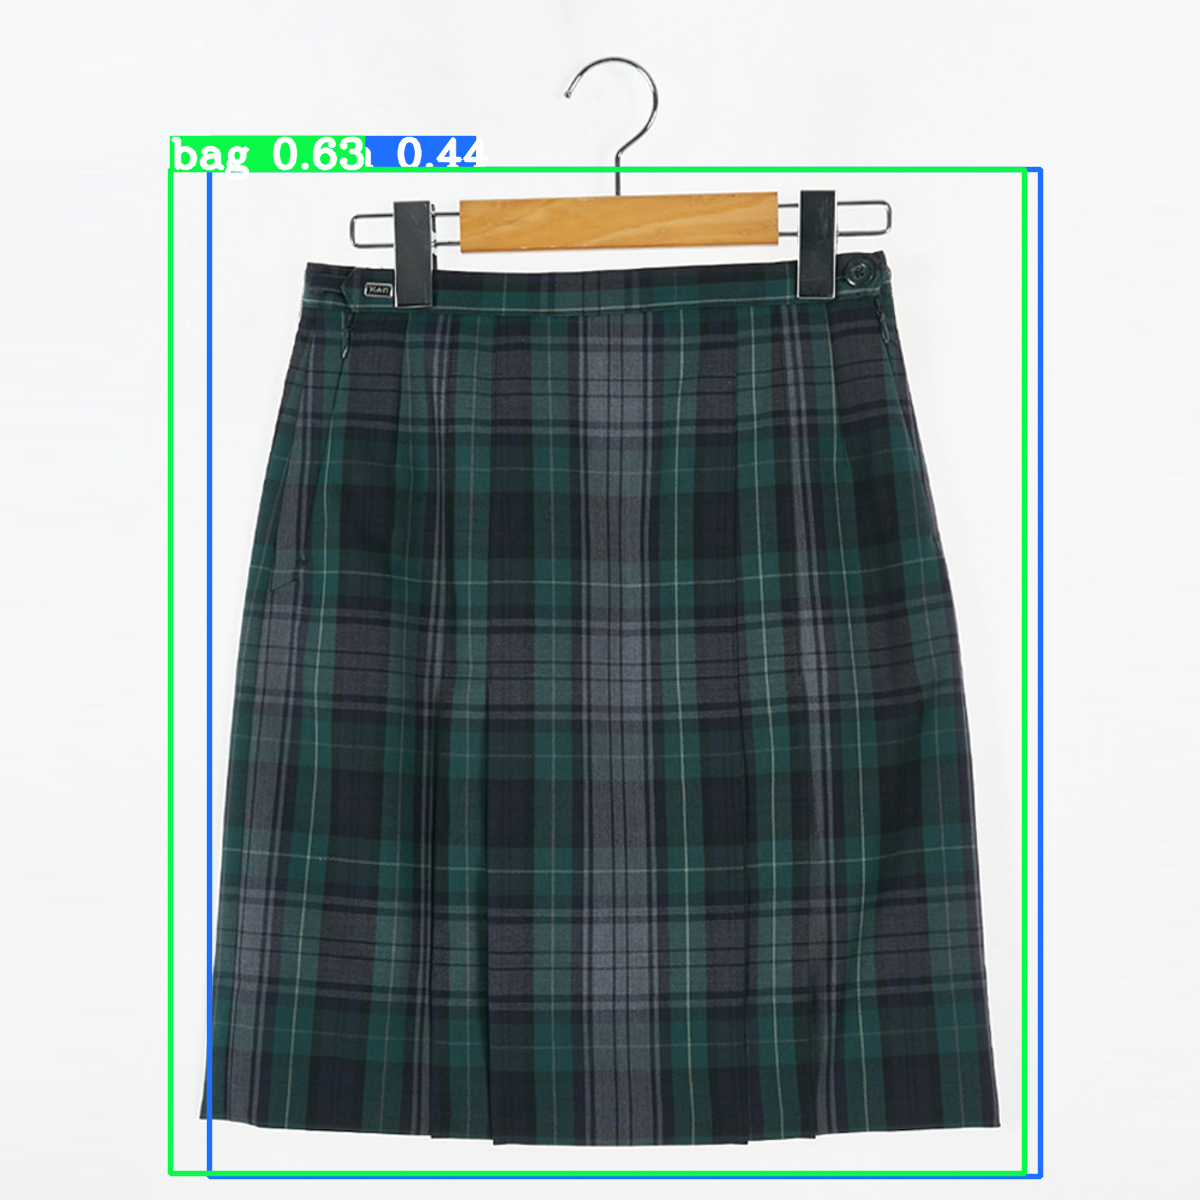

In [ ]:
#@title Run YOLOv6 on an image from a URL. { run: "auto" }
url:str = "/content/66b27997-48f9-4f21-96a8-414728f48437.jpg" #@param {type:"string"}
hide_labels: bool = False #@param {type:"boolean"}
hide_conf: bool = False #@param {type:"boolean"}

img_size:int = 640#@param {type:"integer"}

conf_thres: float =.25 #@param {type:"number"}
iou_thres: float =.45 #@param {type:"number"}
max_det:int =  1000#@param {type:"integer"}
agnostic_nms: bool = False #@param {type:"boolean"}

img_size = check_img_size(img_size, s=stride)

img, img_src = process_image(url, img_size, stride, half)
img = img.to(device)

if len(img.shape) == 3:
    img = img[None]
    # expand for batch dim
pred_results = model(img)
classes:Optional[List[int]] = [0,1,2,3,4,5,6,7] # the classes to keep
det = non_max_suppression(pred_results, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)[0]

print(det)

for d in det:
    
    print(d[5].item())

gn = torch.tensor(img_src.shape)[[1, 0, 1, 0]]  # normalization gain whwh
img_ori = img_src.copy()
if len(det):
  det[:, :4] = Inferer.rescale(img.shape[2:], det[:, :4], img_src.shape).round()
  for *xyxy, conf, cls in reversed(det):
      class_num = int(cls)
      print(class_num)
          
      label = None if hide_labels else (class_names[class_num] if hide_conf else f'{class_names[class_num]} {conf:.2f}')
      Inferer.plot_box_and_label(img_ori, max(round(sum(img_ori.shape) / 2 * 0.003), 2), xyxy, label, color=Inferer.generate_colors(class_num, True))
PIL.Image.fromarray(img_ori)

In [ ]:
PIL.Image.fromarray(img_ori).save("output.jpg")

In [ ]:
pred_results

tensor([[[5.96482e+00, 3.65967e+00, 1.17514e+01,  ..., 3.97825e-03, 3.91378e-03, 6.02461e-03],
         [1.03261e+01, 3.52074e+00, 2.16696e+01,  ..., 2.99862e-03, 3.34629e-03, 4.40359e-03],
         [1.77390e+01, 3.45714e+00, 3.58147e+01,  ..., 3.39809e-03, 3.63521e-03, 5.14329e-03],
         ...,
         [5.02613e+02, 4.49290e+02, 2.76564e+02,  ..., 5.15104e-03, 5.44101e-03, 5.60595e-03],
         [5.38107e+02, 4.60418e+02, 2.14435e+02,  ..., 5.20003e-03, 5.32511e-03, 5.52899e-03],
         [5.88126e+02, 4.67844e+02, 1.31987e+02,  ..., 5.88921e-03, 5.70755e-03, 6.03257e-03]]])

In [ ]:
class_names

['top', 'bottom', 'onepiece', 'outer']

In [ ]:
det.shape

torch.Size([0, 6])

In [ ]:
det

tensor([[259.00000,   4.00000, 534.00000, 784.00000,   0.91903,   0.00000]])